# The LSTM Network


Long Short Term Memory networks - LSTM là một dạng của RNN được sử dụng nhằm khắc phục nhược điểm của mạng RNN truyền thống đó là vấn đề học các phụ thuộc dài hạn (long-term dependencies). Việc LSTM có thể khắc phục được vấn đề này bởi vì nó sử dụng 4 neural tương tác với nhau để hỗ trợ quá trình ghi nhớ, chỉnh sửa thông tin bên trong thay vì chỉ duy nhất 1 neural như với mô hình RNN.

![image](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

LSTM có thể hiểu cơ bản là sự lặp lại các module chứa các layer tương tác với nhau (Nguồn: [colah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/))

Về cơ bản LSTM là một ô trạng thái (cell state), nếu không có sự tương tác với các cổng bên dưới thì mỗi ô chỉ chứa duy nhất 1 đường thẳng  nằm trên cùng chạy ngang hết cell state. Do không có sự tương tác giữa các cổng nên thông tin cơ bản sẽ không bị thay đổi.

![image](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png)

# Step-by-Step LSTM Walk Through

## The Forget Gate
Cổng quên nơi sẽ nhận thông tin đầu vào và hidden state trước đó và áp dụng phép biến đổi tuyến tính cùng với sigmoid function. Đầu ra của hàm sigmoid sẽ cho ra một giá trị từ 0 đến 1. Nhờ tính chất này cổng quên có thể **quên đi** những thông tin phía trước khi kết quả của sigmoid function là 0. Ngược lại với một giá trị lớn hơn 0 sẽ đại diện cho việc chúng ta sẽ ghi nhớ bao nhiêu lượng thông tin đầu.

![image](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png)

Lượng thông tin $f_t$ sau đó sẽ được kết hợp với cell state trước đó. Ta có thể viết lại công thức như sau:

$$
f_t = \sigma(U_fx_t+V_fh_{t-1}+b_f) 
$$

$$
C^{'}_t = f_tC_{t-1}
$$

Với $b_f$ là bias tại forget layer và $U_f, V_f$ là trọng số.

## Input gate

Cổng input được xem như là giải pháp cho việc lưu trữ thông tin dài hạn của LSTM. Tại đây input gate sẽ kết hợp giá trị giữa thông tin đầu vào và hidden state trước đó. Lượng thông tin sau cùng sẽ được kết hợp với lượng thông tin đầu ra tại cổng forget được minh họa dưới hình sau

![imageimage](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png)

Với $b_i, U_i, V_i$ lần lượt là bias và trọng số tương ứng với input layer. $b_c, U_c, V_c$ lần lượt là bias và trọng số tương ứng với concat layer. Hàm sigmoid tại input layer đại diện cho việc chúng ta sẽ sử dụng bao nhiêu lượng thông tin đầu vào. Hàm tanh sẽ thể hiện cho việc quyết định lấy lượng thông tin gốc hay không. 

$$
i_t = \sigma(U_ix_t + V_ih_{t-1} + b_i)
$$

$$
C^+_t = tanh(U_cx_t + V_ch_{t-1} + b_c)
$$

$$
C_t = C^{'}_t + i_tC^+_t
$$

## Output gate
Với cổng output chúng ta sẽ quyết định những thông tin nào sẽ được đi ra. Đầu tiên sử dụng sigmoid để lấy một phần thông tin đầu vào và hidden state. Tiếp theo kết quả sẽ được tính toán với cell state bên trong hàm tanh để cho ra phần thông tin cuối cùng.

![imageimage](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png)

Với $b_o, U_o, V_o$ lần lượt là bias và trọng số tương ứng với output layer.

$$
o_t = \sigma(U_ox_t+V_oh_{t-1}+b_o)
$$

$$
h_t = o_t tanh(C_t)
$$

# Thực nghiệm
Sử dụng Tweet dataset được cung cấp bởi cuộc thi "Natural Language Processing with Disaster Tweets: Predict which Tweets are about real disasters and which ones are not" trên [**kaggle**](https://www.kaggle.com/c/nlp-getting-started)

## Download data

In [1]:
!gdown --id 1jk4z9Cz1zYWrDR56x2t-jLm3dHR71TlR

Downloading...
From: https://drive.google.com/uc?id=1jk4z9Cz1zYWrDR56x2t-jLm3dHR71TlR
To: /content/tweets.csv
100% 996k/996k [00:00<00:00, 67.7MB/s]


## Download glove embeddings

## Libs

In [2]:
import re 
import os
import random
import math
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd 
import string as pystring 

from typing import List
from collections import Counter 
from itertools import chain 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 

from torchtext.vocab import Vectors, GloVe
from torchtext.legacy.data import Field, LabelField, Pipeline, TabularDataset, BucketIterator, Dataset 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Create dataset

In [3]:
df = pd.read_csv("tweets.csv")
df = df.drop(columns=['id', 'keyword', 'location'])

In [4]:
df_train, df_test = train_test_split(df, shuffle=True)
df_train, df_val = train_test_split(df_train, shuffle=True)
print(df_train.shape, df_test.shape, df_val.shape)

(4281, 2) (1904, 2) (1428, 2)


In [5]:
df_train.to_csv("train.csv", index=False)
df_test.to_csv("test.csv", index=False)
df_val.to_csv("val.csv", index=False)

## Preprocess text

In [6]:
def preprocess_text(string):
  p = re.compile(r'<[^<>]+>')
  string = p.sub(" ", string)
  replace_chars = ["\n", "\t", "_"] + list(pystring.punctuation)
  for char in replace_chars:
    string = string.replace(char, " ")
  
  return string.lower()

In [7]:
def load_data(input_dir, source_dir=None, batch_size=16, max_vocab=40000, min_freq=20, glove_dim=300, glove_name="6B"):
  # Read csv, preprocessing
  print("[INFO] Preprocessing Data")
  if source_dir != None:
      load_data_from_file(source_dir, input_path)
  
  tokenize = lambda x: x.split()
  text_field = Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True) # include lenth = 1000
  label_field = LabelField()
  
  fields = [('text', text_field), ('target', label_field)]

  train, valid, test = TabularDataset.splits(path=input_dir,
                                             train='train.csv',
                                             validation='val.csv',
                                             test='train.csv',
                                             format='CSV', fields=fields, skip_header=True)
  
  text_field.build_vocab(train, max_size=max_vocab, min_freq=min_freq, vectors=GloVe(name=glove_name, dim=glove_dim))
  label_field.build_vocab(train)
  word_embeddings = text_field.vocab.vectors
  vocab_size = len(text_field.vocab)

  print ("[INFO] Length of Text Vocabulary: " + str(len(text_field.vocab)))
  print ("[INFO] Vector size of Text Vocabulary: ", text_field.vocab.vectors.size())
  print ("[INFO] Label Length: " + str(len(label_field.vocab)))

  train_loader, valid_loader, test_loader = BucketIterator.splits((train, valid, test),
                                                              batch_size=32, sort_key=lambda x: len(x.text),
                                                              repeat=False, sort=True, shuffle=True)
  
  return text_field, vocab_size, word_embeddings, train_loader, valid_loader, test_loader

In [8]:
text_field, vocab_size, word_embeddings, train_loader, valid_loader, test_loader = load_data(".")

[INFO] Preprocessing Data


.vector_cache/glove.6B.zip: 862MB [02:41, 5.34MB/s]                           
100%|█████████▉| 399999/400000 [00:48<00:00, 8299.98it/s]


[INFO] Length of Text Vocabulary: 371
[INFO] Vector size of Text Vocabulary:  torch.Size([371, 300])
[INFO] Label Length: 2


In [9]:
class LSTMClassifier(nn.Module):
  def __init__(self, vocab_size, output_size=2, hidden_size=256, embedding_size=300, weights=None, dropout_ratio=0.5, LSTM_layers=1):
    super(LSTMClassifier, self).__init__()

    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size

    self.word_embeddings = nn.Embedding(vocab_size, embedding_size)
    if weights != None:
      self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False)

    self.lstm = nn.LSTM(embedding_size, hidden_size, LSTM_layers, batch_first=True, dropout=dropout_ratio)
    self.fc = nn.Linear(hidden_size, output_size)


  def forward(self, input):
    input_embedding = self.word_embeddings(input)

    output_lstm, (final_hidden_state, final_cell_state) = self.lstm(input_embedding)

    final_output = self.fc(final_hidden_state[-1,:,:])
    final_output = torch.squeeze(final_output)

    return final_output

## Train

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMClassifier(vocab_size=vocab_size, weights=word_embeddings)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [11]:
def evaluate(model, val_loader):
    model.eval()
    valid_loss = 0
    nparr_predict_all = np.array([], dtype=int)
    nparr_label_all = np.array([], dtype=int)
    with torch.no_grad():
        for _ , (data, label) in enumerate(val_loader):      
            (input, len_input) = data     
            input = input.to(device)
            label = label.to(device)

            y_pred = model(input)

            loss = F.cross_entropy(y_pred, label)

            valid_loss += loss.item()

            label = label.data.cpu().numpy()
            predict = torch.max(y_pred.data, 1)[1].cpu().numpy()
            nparr_label_all = np.append(nparr_label_all, label)
            nparr_predict_all = np.append(nparr_predict_all, predict)
    
    val_epoch_loss = valid_loss / len(val_loader)
    val_epoch_acc = accuracy_score(nparr_label_all, nparr_predict_all)
    val_precision = precision_score(nparr_label_all, nparr_predict_all)
    val_recall= recall_score(nparr_label_all, nparr_predict_all)
    val_f1_score = f1_score(nparr_label_all, nparr_predict_all)

    return val_epoch_loss, val_epoch_acc, val_precision, val_recall, val_f1_score

def train_model(model, model_dir, model_name, train_loader, val_loader, optimizer, n_epochs=25, eval_every=100):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    new_model_dir = os.path.join(model_dir, model_name)
    if not os.path.exists(new_model_dir):
      os.mkdir(new_model_dir)

    valid_loss_min = np.Inf
    global_step = 0 
    global_steps_list = []
    train_loss_list, train_acc_list = [], []
    valid_loss_list, valid_acc_list = [], []

    train_precision_list, valid_precision_list = [], []
    train_recall_list, valid_recall_list = [], []
    train_f1_list, valid_f1_list = [], []

    # train the model 
    model.train()
    for epoch in range(1, n_epochs):
        train_loss = 0

        nparr_predict_all = np.array([], dtype=int)
        nparr_label_all = np.array([], dtype=int)
        for _ , (data, label) in enumerate(train_loader):
            (input, len_input) = data         
            input = input.to(device)
            label = label.to(device)

            y_pred = model(input)

            loss = F.cross_entropy(y_pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running value
            train_loss += loss.item()
            global_step += 1

            label = label.data.cpu().numpy()
            predict = torch.max(y_pred.data, 1)[1].cpu().numpy()
            nparr_label_all = np.append(nparr_label_all, label)
            nparr_predict_all = np.append(nparr_predict_all, predict)
        
        train_epoch_loss = train_loss / len(train_loader)
        train_epoch_acc = accuracy_score(nparr_label_all, nparr_predict_all)
        train_precision = precision_score(nparr_label_all, nparr_predict_all)
        train_recall= recall_score(nparr_label_all, nparr_predict_all)
        train_f1_score = f1_score(nparr_label_all, nparr_predict_all)
                    
        # validate the model 
        val_epoch_loss, val_epoch_acc, val_precision, val_recall, val_f1_score = evaluate(model, val_loader)

        # add history
        train_loss_list.append(train_epoch_loss) 
        train_acc_list.append(train_epoch_acc)
        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1_score)

        valid_loss_list.append(val_epoch_loss)
        valid_acc_list.append(val_epoch_acc)
        valid_precision_list.append(val_precision)
        valid_recall_list.append(val_recall)
        valid_f1_list.append(val_f1_score)

        # reset training
        model.train()
        
        # print training/validation statistics 
        print('Epoch: {}, Training Loss: {:.6f}, Training Acc: {:.6} || Validation Loss: {:.6f}, Validation Acc: {:.6f}'.
              format(epoch, train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc))
        
        ## TODO: save the model if validation loss has decreased
        if val_epoch_loss < valid_loss_min:
            save_model_name = "{}_loss_{:.6f}_acc_{:.6f}.pt".format(model_name, val_epoch_loss, val_epoch_acc)
            model_path = os.path.join(new_model_dir, save_model_name)
            torch.save(model, model_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving {} ....'.format(
            valid_loss_min,
            val_epoch_loss,
            model_path))
            valid_loss_min = val_epoch_loss
        
            
    # return trained model
    return model, save_model_name, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list

In [12]:
model_dir = "models"
model_name = "lstm"
if not os.path.exists(model_dir):
  os.mkdir(model_dir)

trained_model, save_model_name, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = \
    train_model(model, model_dir, model_name, train_loader, valid_loader, optimizer, n_epochs=5, eval_every=100)

Epoch: 1, Training Loss: 0.578326, Training Acc: 0.697267 || Validation Loss: 0.555395, Validation Acc: 0.721289
Validation loss decreased (inf --> 0.555395).  Saving models/lstm/lstm_loss_0.555395_acc_0.721289.pt ....
Epoch: 2, Training Loss: 0.529002, Training Acc: 0.750759 || Validation Loss: 0.582289, Validation Acc: 0.706583
Epoch: 3, Training Loss: 0.517674, Training Acc: 0.758 || Validation Loss: 0.619588, Validation Acc: 0.640756
Epoch: 4, Training Loss: 0.519845, Training Acc: 0.758234 || Validation Loss: 0.582466, Validation Acc: 0.704482


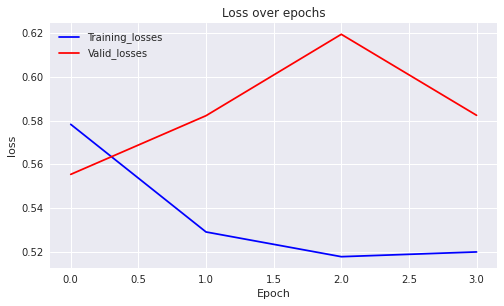

In [13]:
plt.style.use('seaborn')
train_losses = np.array(train_loss_list)
valid_losses = np.array(valid_loss_list)

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.plot(train_losses, color="blue", label="Training_losses")
ax.plot(valid_losses, color="red", label="Valid_losses")
ax.set(title="Loss over epochs",
       xlabel="Epoch",
       ylabel="loss")
ax.legend()
fig.show()

plt.style.use('default')

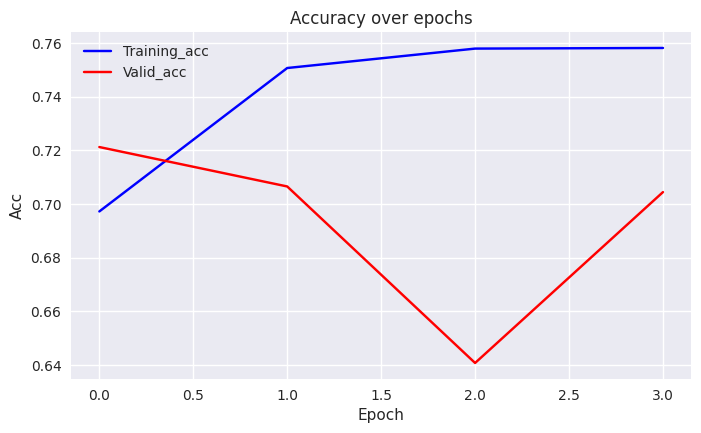

In [14]:
plt.style.use('seaborn')
train_acc = np.array(train_acc_list)
valid_acc= np.array(valid_acc_list)

fig, ax = plt.subplots(figsize=(8, 4.5))

ax.plot(train_acc, color="blue", label="Training_acc")
ax.plot(valid_acc, color="red", label="Valid_acc")
ax.set(title="Accuracy over epochs",
       xlabel="Epoch",
       ylabel="Acc")
ax.legend()
fig.show()

plt.style.use('default')

## Test

In [17]:
loaded_model = torch.load("model.pt")

In [19]:
test_loss, test_acc, test_precision, test_recall, test_f1_score = evaluate(model, test_loader)

In [20]:
print("test_acc: ", test_acc)
print("test_precision: ", test_precision)
print("test_recall: ", test_recall)
print("test_f1_score: ", test_f1_score)

test_acc:  0.7175893482831114
test_precision:  0.8478260869565217
test_recall:  0.42184964845862627
test_f1_score:  0.5633802816901408
